In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from tensorflow.keras import layers

import gym
from gym.wrappers import AtariPreprocessing, FrameStack
import numpy as np
import tensorflow as tf

# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
max_episodes = 10  # Limit training episodes, will run until solved if smaller than 1

# Use the Atari environment
# Specify the `render_mode` parameter to show the attempts of the agent in a pop up window.
env = gym.make("BreakoutNoFrameskip-v4")  # , render_mode="human")
# Environment preprocessing
env = AtariPreprocessing(env)
# Stack four frames
env = FrameStack(env, 4)
env.seed(seed)

2024-05-09 00:36:31.173862: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 00:36:31.202969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 00:36:31.202997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 00:36:31.203807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 00:36:31.209533: I tensorflow/core/platform/cpu_feature_guar

(3444837047, 2669555309)

In [2]:
num_actions = 4


def create_q_model():
    # Network defined by the Deepmind paper
    return tf.keras.models.Sequential(
        [
            layers.Lambda(
                lambda tensor: tf.transpose(tensor, [0, 2, 3, 1]),
                output_shape=(84, 84, 4),
                input_shape=(4, 84, 84),
            ),
            # Convolutions on the frames on the screen
            layers.Conv2D(32, 8, strides=4, activation="relu", input_shape=(4, 84, 84)),
            layers.Conv2D(64, 4, strides=2, activation="relu"),
            layers.Conv2D(64, 3, strides=1, activation="relu"),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dense(num_actions, activation="linear"),
        ]
    )


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()

2024-05-09 00:36:34.991305: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 00:36:35.038537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 00:36:35.038572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 00:36:35.041221: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 00:36:35.041262: I external/local_xla/xla/stream_executor

In [8]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

while True:
    observation, _ = env.reset()
    state = np.array(observation)
    episode_reward = 0
    rewards_avg=[]
    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1
    
    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

    if (
        max_episodes > 0 and episode_count >= max_episodes
    ):  # Maximum number of episodes reached
        print("Stopped at episode {}!".format(episode_count))
        break

1/1 [==============================] - 0s 13ms/step


2024-05-09 00:41:39.086356: I external/local_xla/xla/service/service.cc:168] XLA service 0x560240125870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-09 00:41:39.086395: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-09 00:41:39.106499: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715211699.235887   18375 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 0s 12ms/step
Stopped at episode 10!


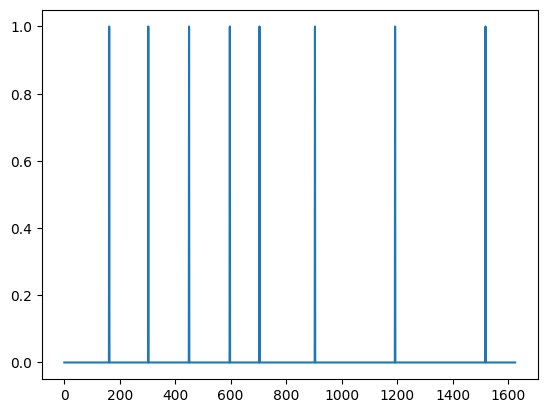

In [10]:
from matplotlib import pyplot as plt
plt.plot(rewards_history)